# Notebook showing SVD analysis of candidate library after the refinement step in SODAs

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import sys
import os

# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
# Add the path to the sys.path
sys.path.append(path_to_add)

from matplotlib import pyplot as plt

### MM chemical reaction system

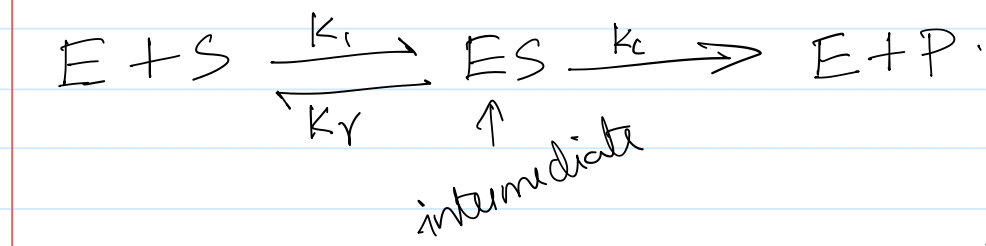

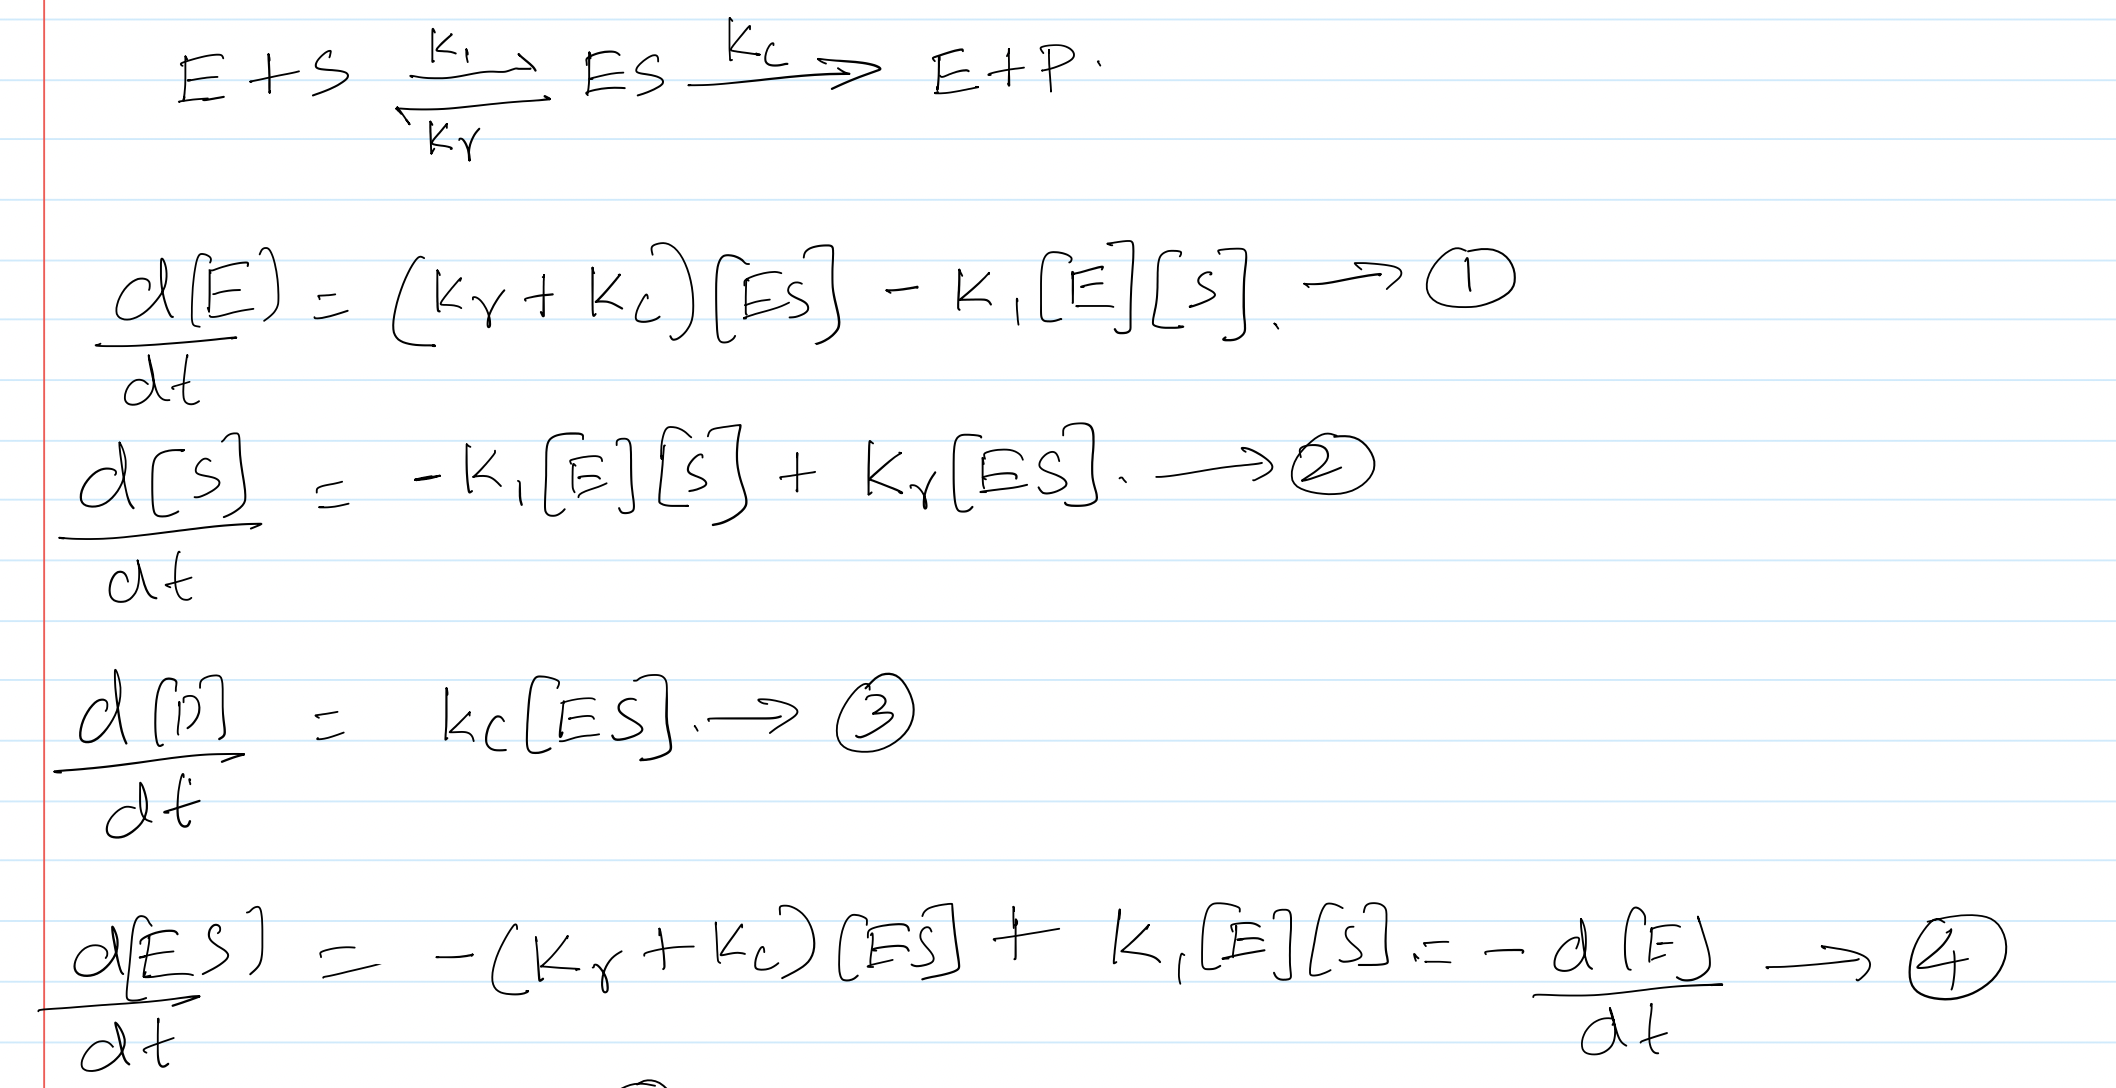

### Michaelis Mentin approximation

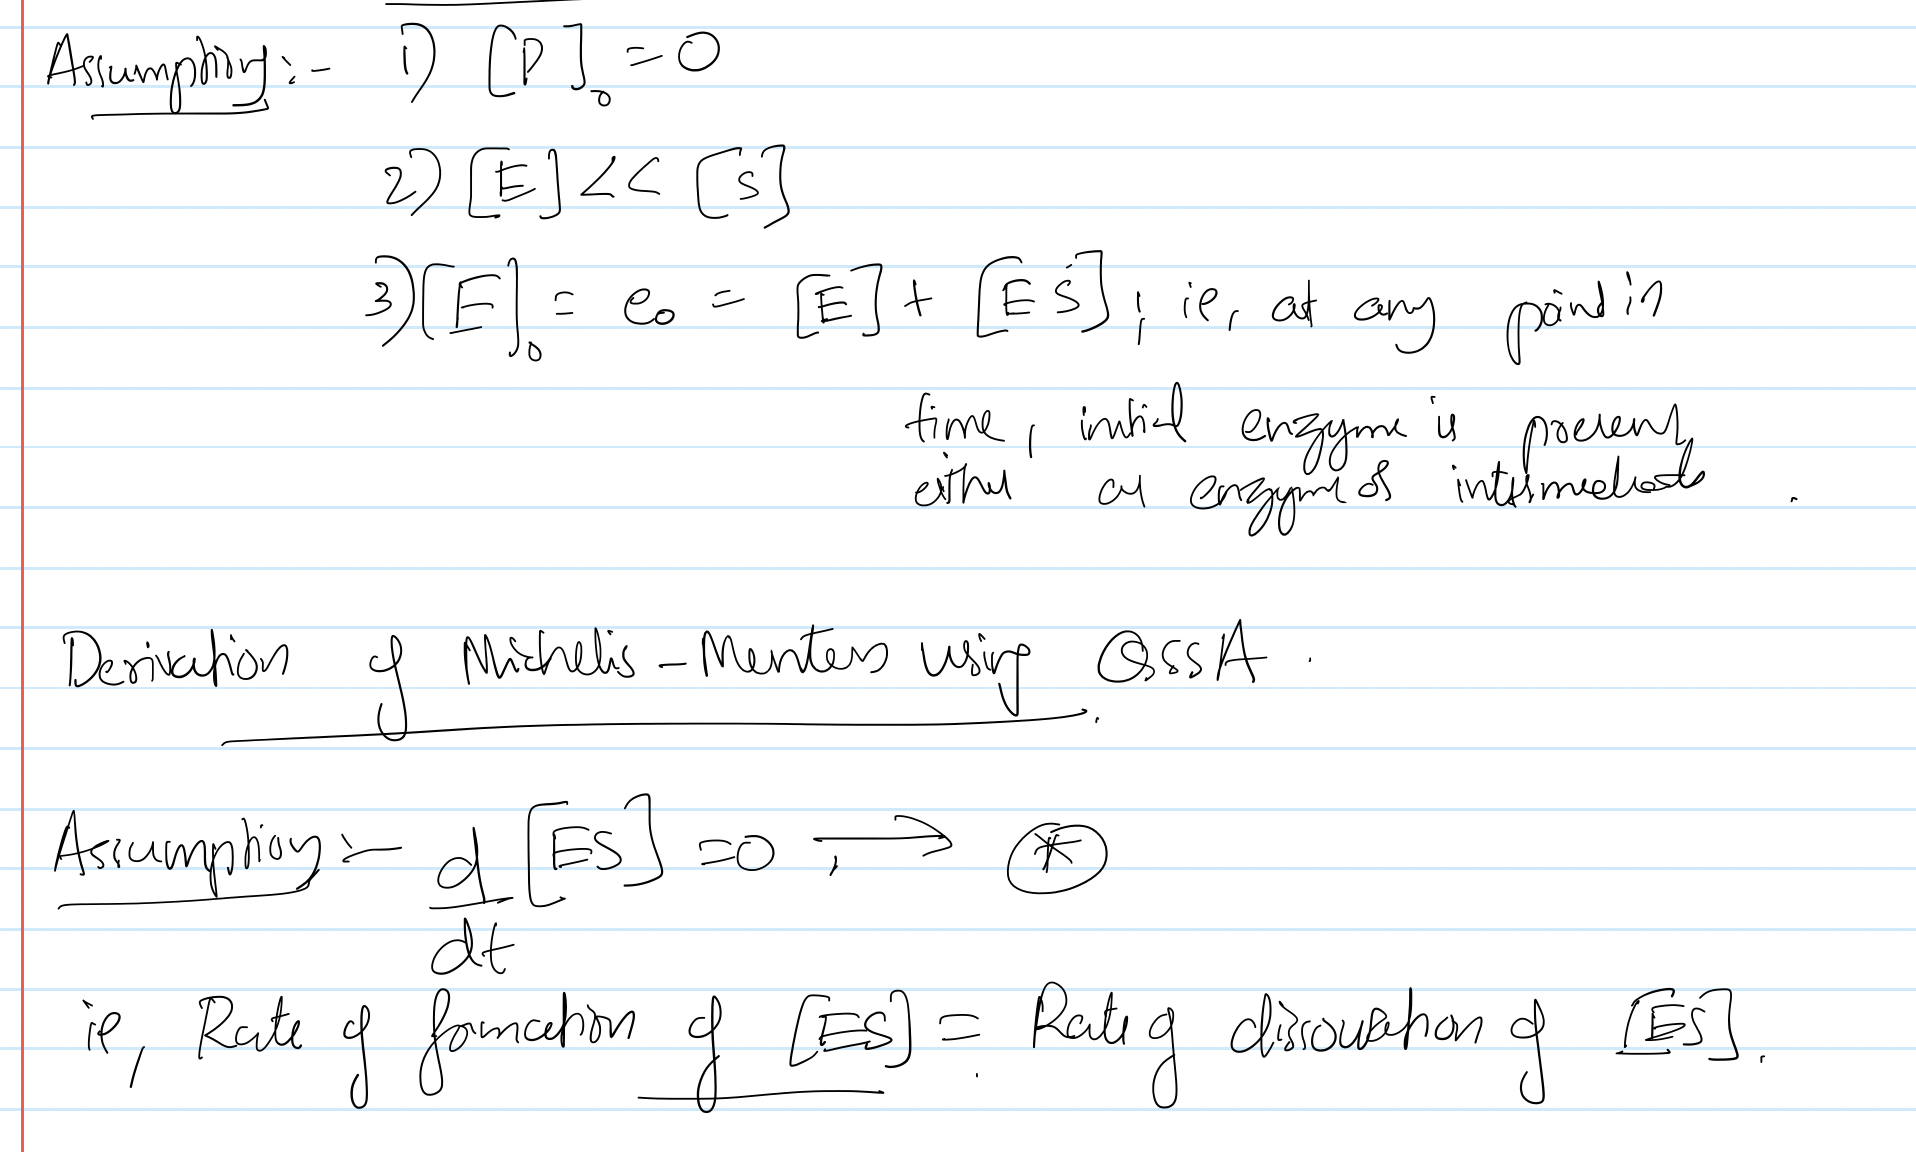

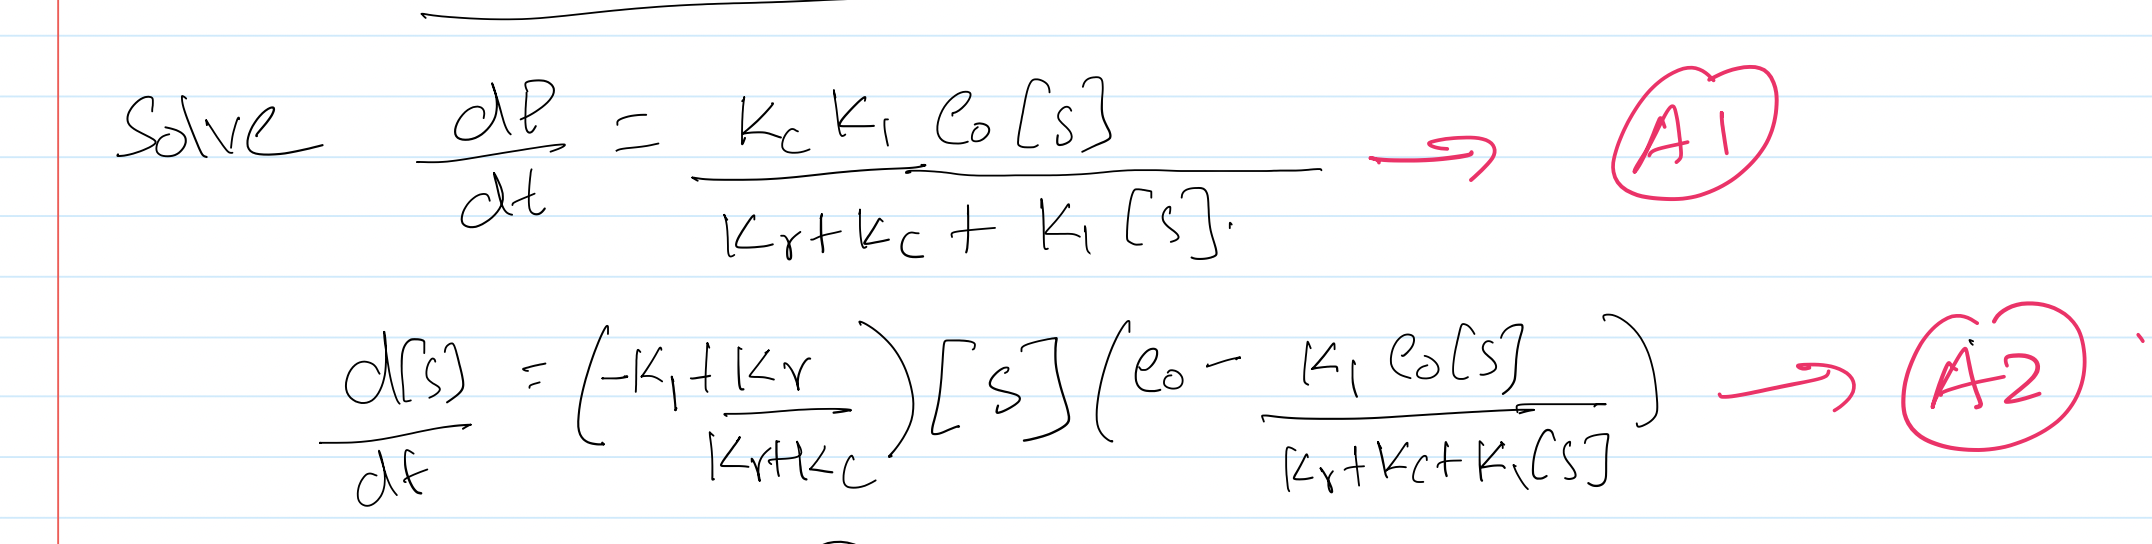

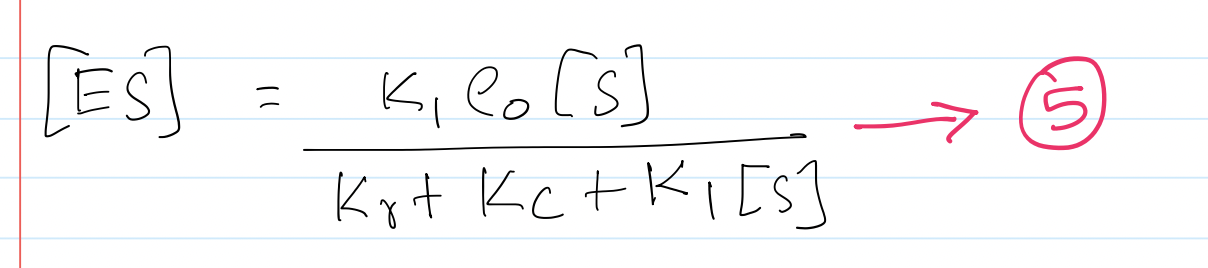

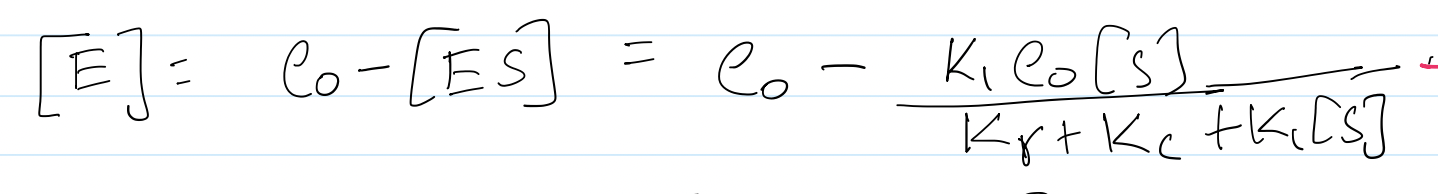


# Generating time series data

#### Loading intial conditions

In [2]:
k_rates_df = pd.read_csv(os.path.join(path_to_add, "parameters/k_rates_param.csv"))

In [3]:
k_rates_df

k         kr       kcat
0 2.12456000 1.10124000 1.50930000

#### Loading params

In [4]:
IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond.csv"))

# IC_df = IC_df.drop([2,4,5,8], axis = 0)
# IC_df = IC_df[0:6]
IC_df

S  E  ES  P
0  2.50000000  2   0  0
1  2.75000000  2   0  0
2  3.00000000  2   0  0
3  3.25000000  2   0  0
4  3.50000000  2   0  0
5  4.00000000  2   0  0
6  4.50000000  2   0  0
7  5.00000000  2   0  0
8  6.00000000  2   0  0
9  6.50000000  2   0  0
10 7.50000000  2   0  0
11 8.50000000  2   0  0
12 9.00000000  2   0  0
13 9.50000000  2   0  0

In [5]:
from dae_finder import solveMM, plotToy_MM

#### Plotting solutions to different IC

In [6]:
refinement_level = 2
final_time = 4
num_time_points = 500
t_span = (0, final_time)
time_grid_1 = np.linspace(0, final_time, num_time_points)
data_matrix_df_list = []

def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]

for k_rate_index in k_rates_df.index:
    k_rates = k_rates_df.loc[k_rate_index]
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        # data_matrix_df_list.append(solveMM(IC, k_rates, time_grid_1, "dense"))
        sol = solveMM(IC, k_rates, time_grid_1, "dense")
        sol_df = pd.DataFrame(sol, columns=IC.keys())
        sol_df["t"] = time_grid_1
        data_matrix_df_list.append(sol_df.rename(columns=dict(zip(sol_df.columns, get_block_symbol(sol_df.columns)))))

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

[S]        [E]       [ES]        [P]        [t]
0    2.50000000 0.65906583 1.34093417 0.00000000 0.00000000
1    2.48379397 0.66194280 1.33805720 0.01620603 0.00801603
2    2.46762286 0.66483871 1.33516129 0.03237714 0.01603206
3    2.45148688 0.66775370 1.33224630 0.04851312 0.02404810
4    2.43538629 0.67068788 1.32931212 0.06461371 0.03206413
...         ...        ...        ...        ...        ...
6995 0.70981041 1.26769095 0.73230905 8.79018959 3.96793587
6996 0.70098556 1.27348823 0.72651177 8.79901444 3.97595190
6997 0.69223089 1.27929203 0.72070797 8.80776911 3.98396794
6998 0.68354648 1.28510177 0.71489823 8.81645352 3.99198397
6999 0.67493238 1.29091683 0.70908317 8.82506762 4.00000000

[7000 rows x 5 columns]

#### Adding noise

In [7]:
from dae_finder import add_noise_to_df
noise_perc = 15


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["[t]"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["[t]"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

# Data preprocessing

## Artificial altering sampling frequency

### Sampling more from the transition region (Optional)

- If the aplify_factor = 1, no amplification is done (recommended for initial runs)

## Smoothening data using splines

In [8]:
num_smoothed_points = num_time_points
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)

from dae_finder import smooth_data

#Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                          eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
    data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)

In [9]:
data_matrix_df

[S]        [E]       [ES]        [P]        [t]
0    2.50000000 0.65906583 1.34093417 0.00000000 0.00000000
1    2.48379397 0.66194280 1.33805720 0.01620603 0.00801603
2    2.46762286 0.66483871 1.33516129 0.03237714 0.01603206
3    2.45148688 0.66775370 1.33224630 0.04851312 0.02404810
4    2.43538629 0.67068788 1.32931212 0.06461371 0.03206413
...         ...        ...        ...        ...        ...
6995 0.70981041 1.26769095 0.73230905 8.79018959 3.96793587
6996 0.70098556 1.27348823 0.72651177 8.79901444 3.97595190
6997 0.69223089 1.27929203 0.72070797 8.80776911 3.98396794
6998 0.68354648 1.28510177 0.71489823 8.81645352 3.99198397
6999 0.67493238 1.29091683 0.70908317 8.82506762 4.00000000

[7000 rows x 5 columns]

#### Plotting the smoothened splines vs noisy data

In [10]:
data_matrix_df_smooth_appended

[t]        [S]  d([S]) /dt        [E]  d([E]) /dt       [ES]  \
0    0.00000000 2.46516015 -1.77754287 0.62528852  0.44747529 1.38363045   
1    0.00801603 2.45090087 -1.78012870 0.62888949  0.45096333 1.38002256   
2    0.01603206 2.43662132 -1.78260029 0.63251831  0.45442205 1.37638673   
3    0.02404810 2.42232241 -1.78495763 0.63617474  0.45785147 1.37272317   
4    0.03206413 2.40800507 -1.78720072 0.63985854  0.46125157 1.36903214   
...         ...        ...         ...        ...         ...        ...   
6995 3.96793587 0.78150963 -1.02099289 1.27920925  0.76738202 0.73448015   
6996 3.97595190 0.77331481 -1.02367497 1.28537438  0.77081914 0.72848428   
6997 3.98396794 0.76509705 -1.02671849 1.29156710  0.77426483 0.72246216   
6998 3.99198397 0.75685343 -1.03012346 1.29778747  0.77771908 0.71641371   
6999 4.00000000 0.74858107 -1.03388988 1.30403556  0.78118190 0.71033887   

      d([ES]) /dt         [P]  d([P]) /dt  
0     -0.44833047 -0.02164866  2.13380960  
1     -0.45183204 -0.00456793  2.12782840  
2     -0.45530431  0.01246475  2.12182089  
3     -0.45874729  0.02944917  2.11578705  
4     -0.46216098  0.04638512  2.10972690  
...           ...         ...         ...  
6995  -0.74634924  8.89528606  1.38794003  
6996  -0.74962092  8.90639047  1.38260642  
6997  -0.75290062  8.91745207  1.37726140  
6998  -0.75618834  8.92847078  1.37190497  
6999  -0.75948409  8.93944651  1.36653713  

[7000 rows x 9 columns]

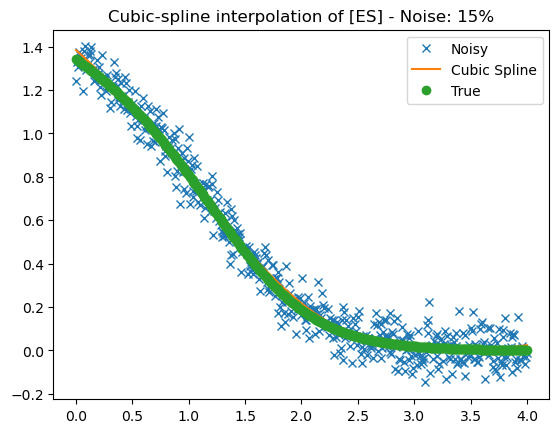

In [11]:
from matplotlib import pyplot as plt
ind = 0
feature_ = "[ES]"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["[t]"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["[t]"],
         data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["[t]"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

# Defining Cadidate library (RHS of equations)

### Using polynomial features inspired from mass action kinetics

In [19]:
from dae_finder import PolyFeatureMatrix

poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

[S]        [E]       [ES]         [P]      [S]^2    [S] [E]  \
0    2.46516015 0.62528852 1.38363045 -0.02164866 6.07701457 1.54143634   
1    2.45090087 0.62888949 1.38002256 -0.00456793 6.00691508 1.54134581   
2    2.43662132 0.63251831 1.37638673  0.01246475 5.93712345 1.54120761   
3    2.42232241 0.63617474 1.37272317  0.02944917 5.86764587 1.54102033   
4    2.40800507 0.63985854 1.36903214  0.04638512 5.79848841 1.54078260   
...         ...        ...        ...         ...        ...        ...   
6995 0.78150963 1.27920925 0.73448015  8.89528606 0.61075731 0.99971435   
6996 0.77331481 1.28537438 0.72848428  8.90639047 0.59801580 0.99399905   
6997 0.76509705 1.29156710 0.72246216  8.91745207 0.58537349 0.98817417   
6998 0.75685343 1.29778747 0.71641371  8.92847078 0.57282712 0.98223490   
6999 0.74858107 1.30403556 0.71033887  8.93944651 0.56037362 0.97617634   

       [S] [ES]     [S] [P]      [E]^2   [E] [ES]     [E] [P]     [ES]^2  \
0    3.41087065 -0.05336741 0.39098573 0.86516823 -0.01353666 1.91443322   
1    3.38229850 -0.01119554 0.39550200 0.86788169 -0.00287272 1.90446227   
2    3.35373324  0.03037188 0.40007942 0.87058981  0.00788418 1.89444042   
3    3.32517811  0.07133539 0.40471830 0.87329181  0.01873482 1.88436891   
4    3.29663633  0.11169560 0.40941895 0.87598690  0.02967991 1.87424900   
...         ...         ...        ...        ...         ...        ...   
6995 0.57400331  6.95175176 1.63637631 0.93955380 11.37893223 0.53946109   
6996 0.56334769  6.88744368 1.65218730 0.93637503 11.44804613 0.53068935   
6997 0.55275366  6.82271623 1.66814556 0.93310835 11.51748767 0.52195157   
6998 0.54222017  6.75754375 1.68425231 0.92975273 11.58725748 0.51324860   
6999 0.53174624  6.69190047 1.70050875 0.92630715 11.65735614 0.50458132   

        [ES] [P]       [P]^2  
0    -0.02995374  0.00046866  
1    -0.00630384  0.00002087  
2     0.01715632  0.00015537  
3     0.04042556  0.00086725  
4     0.06350272  0.00215158  
...          ...         ...  
6995  6.53341102 79.12611417  
6996  6.48816545 79.32379115  
6997  6.44252164 79.52095140  
6998  6.39647886 79.71759046  
6999  6.35003636 79.91370385  

[7000 rows x 14 columns]

# Variance explained analysis

In [20]:
#Adding the features as symbols (Required for library refinement). 
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [21]:
from matplotlib import pyplot as plt
from sklearn import decomposition



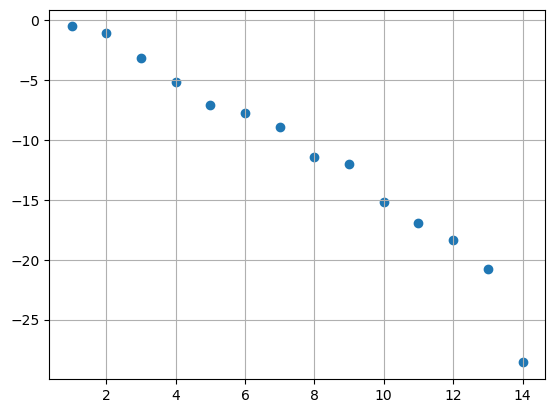

In [22]:
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)

sing_vals_1 = pca_1.explained_variance_ratio_

plt.scatter(np.arange(1, len(sing_vals_1)+1),np.log(sing_vals_1))
plt.grid()


# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)


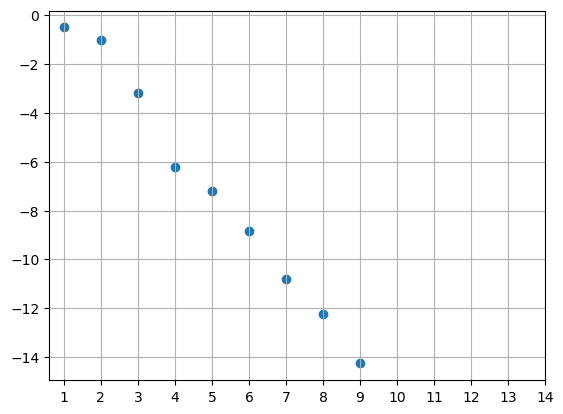

In [23]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

pca_2 = decomposition.PCA()
pca_2.fit(refined_candid_lib)

sing_vals_2 = pca_2.explained_variance_ratio_

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2))

plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()



([<matplotlib.axis.XTick at 0x13ddbe930>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14')])

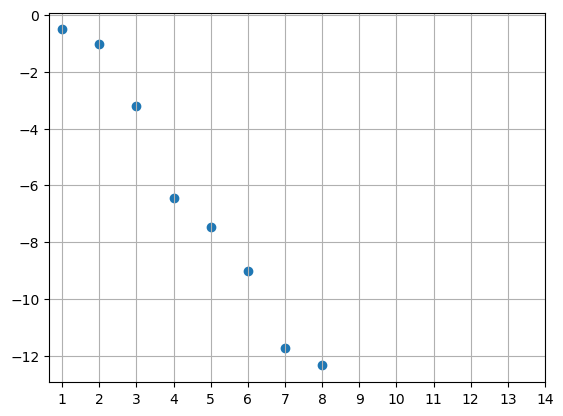

In [24]:

features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

pca_3 = decomposition.PCA()
pca_3.fit(refined_candid_lib)

sing_vals_3 = pca_3.explained_variance_ratio_

plt.scatter(np.arange(1,len(sing_vals_3)+1),np.log(sing_vals_3))
plt.grid()
plt.xticks(range(1, len(sing_vals_1)+1, 1))

# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)


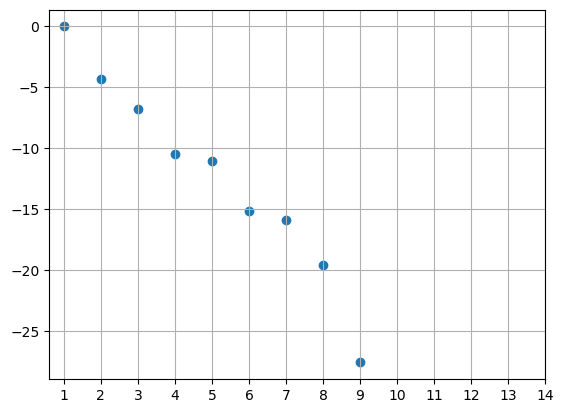

In [25]:
features_to_remove = {P}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

pca_4 = decomposition.PCA()
pca_4.fit(refined_candid_lib)

sing_vals_4 = pca_4.explained_variance_ratio_

plt.scatter(np.arange(1, len(sing_vals_4)+1),np.log(sing_vals_4))

plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()



## Combined

In [26]:
#Adding the features as symbols (Required for library refinement). 
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

### Clean

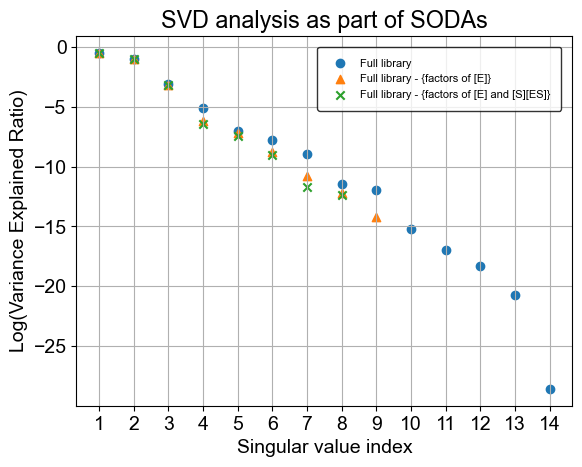

In [28]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)
sing_vals_1 = pca_1.explained_variance_ratio_



features_to_remove = {E}
features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                               candidate_lib_full, get_dropped_feat=True)
pca_2 = decomposition.PCA()
pca_2.fit(refined_candid_lib)
sing_vals_2 = pca_2.explained_variance_ratio_



features_to_remove_2 = {E, S*ES}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove_2, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)
pca_4 = decomposition.PCA()
pca_4.fit(refined_candid_lib_2)
sing_vals_4 = pca_4.explained_variance_ratio_

def find_log_values(values_list):
    return [max(-32, np.log(val)) if abs(val)>1e-32 else -32 for val in values_list ]

plt.scatter(np.arange(1, len(sing_vals_1)+1),find_log_values(sing_vals_1), label="Full library", marker='o')
plt.scatter(np.arange(1, len(sing_vals_2)+1),find_log_values(sing_vals_2), label="Full library - {factors of [E]}", marker='^')
plt.scatter(np.arange(1, len(sing_vals_4)+1),find_log_values(sing_vals_4), label="Full library - {factors of [E] and [S][ES]}",
            marker='x')
# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

# plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()
plt.title("SVD analysis as part of SODAs")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Variance Explained Ratio)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)

plt.savefig('figures/svd_clean.svg', format='svg', bbox_inches='tight')

### Noisy

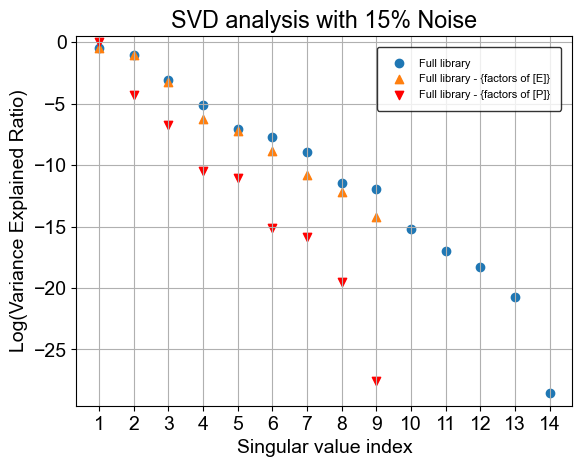

In [30]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)
sing_vals_1 = pca_1.explained_variance_ratio_



features_to_remove = {E}
features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                               candidate_lib_full, get_dropped_feat=True)
pca_2 = decomposition.PCA()
pca_2.fit(refined_candid_lib)
sing_vals_2 = pca_2.explained_variance_ratio_



features_to_remove_2 = {P}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove_2, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)
pca_4 = decomposition.PCA()
pca_4.fit(refined_candid_lib_2)
sing_vals_4 = pca_4.explained_variance_ratio_


plt.scatter(np.arange(1, len(sing_vals_1)+1),np.log(sing_vals_1), label="Full library", marker='o')
plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label="Full library - {factors of [E]}", marker='^')
plt.scatter(np.arange(1, len(sing_vals_4)+1),np.log(sing_vals_4), label="Full library - {factors of [P]}", marker='v', color="red")
# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

# plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Variance Explained Ratio)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.title("SVD analysis with 15% Noise")

plt.savefig('figures/svd_noisy.svg', format='svg', bbox_inches='tight')

### Noisy higher order library

In [28]:
from dae_finder import PolyFeatureMatrix

poly_degree = 4

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

[S]        [E]       [ES]         [P]      [S]^2    [S] [E]  \
0    2.46516015 0.62528852 1.38363045 -0.02164866 6.07701457 1.54143634   
1    2.45090087 0.62888949 1.38002256 -0.00456793 6.00691508 1.54134581   
2    2.43662132 0.63251831 1.37638673  0.01246475 5.93712345 1.54120761   
3    2.42232241 0.63617474 1.37272317  0.02944917 5.86764587 1.54102033   
4    2.40800507 0.63985854 1.36903214  0.04638512 5.79848841 1.54078260   
...         ...        ...        ...         ...        ...        ...   
6995 0.78150963 1.27920925 0.73448015  8.89528606 0.61075731 0.99971435   
6996 0.77331481 1.28537438 0.72848428  8.90639047 0.59801580 0.99399905   
6997 0.76509705 1.29156710 0.72246216  8.91745207 0.58537349 0.98817417   
6998 0.75685343 1.29778747 0.71641371  8.92847078 0.57282712 0.98223490   
6999 0.74858107 1.30403556 0.71033887  8.93944651 0.56037362 0.97617634   

       [S] [ES]     [S] [P]      [E]^2   [E] [ES]  ...  [E]^2 [P]^2  \
0    3.41087065 -0.05336741 0.39098573 0.86516823  ...   0.00018324   
1    3.38229850 -0.01119554 0.39550200 0.86788169  ...   0.00000825   
2    3.35373324  0.03037188 0.40007942 0.87058981  ...   0.00006216   
3    3.32517811  0.07133539 0.40471830 0.87329181  ...   0.00035099   
4    3.29663633  0.11169560 0.40941895 0.87598690  ...   0.00088090   
...         ...         ...        ...        ...  ...          ...   
6995 0.57400331  6.95175176 1.63637631 0.93955380  ... 129.48009866   
6996 0.56334769  6.88744368 1.65218730 0.93637503  ... 131.05776020   
6997 0.55275366  6.82271623 1.66814556 0.93310835  ... 132.65252234   
6998 0.54222017  6.75754375 1.68425231 0.92975273  ... 134.26453582   
6999 0.53174624  6.69190047 1.70050875 0.92630715  ... 135.89395225   

      [E] [ES]^3  [E] [ES]^2 [P]  [E] [ES] [P]^2    [E] [P]^3     [ES]^4  \
0     1.65630680     -0.02591503      0.00040547  -0.00000634 3.66505455   
1     1.65284794     -0.00547099      0.00001811  -0.00000006 3.62697656   
2     1.64928053      0.01493612      0.00013526   0.00000122 3.58890451   
3     1.64560393      0.03530331      0.00075737   0.00001625 3.55084619   
4     1.64181758      0.05562755      0.00188476   0.00006386 3.51280930   
...          ...             ...             ...          ...        ...   
6995  0.50685271      6.13849115     74.34324120 900.37069065 0.29101826   
6996  0.49692425      6.07535612     74.27681736 908.10242028 0.28163118   
6997  0.48703736      6.01157073     74.20166359 915.88157763 0.27243344   
6998  0.47719429      5.94714369     74.11764745 923.70824601 0.26342413   
6999  0.46739728      5.88208410     74.02463542 931.58250648 0.25460230   

      [ES]^3 [P]  [ES]^2 [P]^2   [ES] [P]^3         [P]^4  
0    -0.05734444    0.00089723  -0.00001404    0.00000022  
1    -0.01200543    0.00003974  -0.00000013    0.00000000  
2     0.03250163    0.00029434   0.00000267    0.00000002  
3     0.07617667    0.00163423   0.00003506    0.00000075  
4     0.11901990    0.00403259   0.00013663    0.00000463  
...          ...           ...          ...           ...  
6995  3.52452101   42.68545954 516.96342618 6260.94194371  
6996  3.44320028   42.09629089 514.66588099 6292.26384180  
6997  3.36268426   41.50608509 512.31545028 6323.58171151  
6998  3.28298382   40.91494176 509.91188184 6354.89422831  
6999  3.20410970   40.32296183 507.45492542 6386.20006270  

[7000 rows x 69 columns]

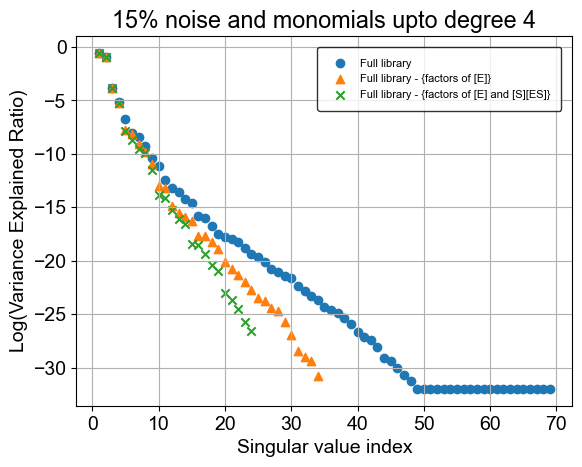

In [32]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)
sing_vals_1 = pca_1.explained_variance_ratio_



features_to_remove = {E}
features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                               candidate_lib_full, get_dropped_feat=True)
pca_2 = decomposition.PCA()
pca_2.fit(refined_candid_lib)
sing_vals_2 = pca_2.explained_variance_ratio_



features_to_remove_2 = {E, S*ES}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove_2, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)
pca_4 = decomposition.PCA()
pca_4.fit(refined_candid_lib_2)
sing_vals_4 = pca_4.explained_variance_ratio_

def find_log_values(values_list):
    return [max(-32, np.log(val)) if abs(val)>1e-32 else -32 for val in values_list ]

plt.scatter(np.arange(1, len(sing_vals_1)+1),find_log_values(sing_vals_1), label="Full library", marker='o')
plt.scatter(np.arange(1, len(sing_vals_2)+1),find_log_values(sing_vals_2), label="Full library - {factors of [E]}", marker='^')
plt.scatter(np.arange(1, len(sing_vals_4)+1),find_log_values(sing_vals_4), label="Full library - {factors of [E] and [S][ES]}",
            marker='x')
# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

# plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

# plt.xticks(range(1, len(sing_vals_1)+1, 1))
# plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()
plt.title("15% noise and monomials upto degree 4")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Variance Explained Ratio)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)

plt.savefig('figures/svd_higher_order.svg', format='svg', bbox_inches='tight')

## SVD only analysis

In [14]:
def find_log_values(values_list):
    return [max(-32, np.log(val)) if abs(val)>1e-32 else -32 for val in values_list ]

### Noise = 0

In [14]:
#Adding the features as symbols (Required for library refinement). 
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

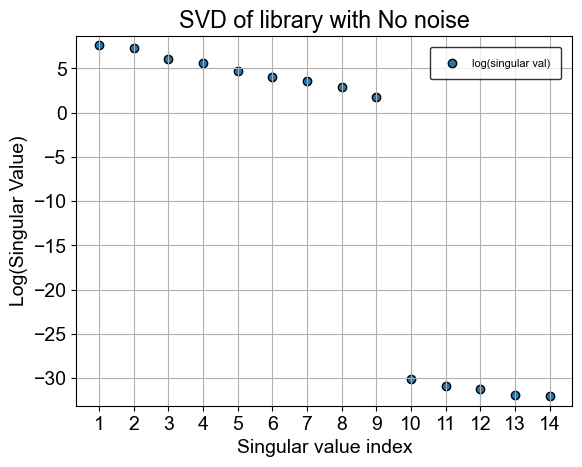

In [34]:
sing_vals_1 = np.linalg.svd(candidate_lib_full)[1]
y_val = np.log(sing_vals_1)
normalized_y = (y_val - np.min(y_val)) / (np.max(y_val) - np.min(y_val))
# Use a colormap (e.g., 'viridis', 'plasma', 'inferno', etc.)
colors = plt.cm.viridis(normalized_y)

plt.scatter(np.arange(1, len(sing_vals_1)+1),find_log_values(sing_vals_1), edgecolor='black', label='log(singular val)')
plt.grid()

# plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')
plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
# plt.legend(loc='lower left')
plt.title('SVD of library with No noise')

plt.savefig('figures/svd_clean_full_1.svg', format='svg', bbox_inches='tight')
# Add a title
# plt.title('SVD ')



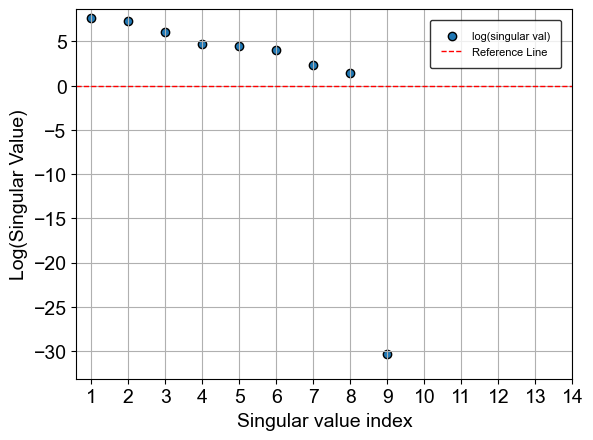

In [16]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(refined_candid_lib)[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), edgecolor='black', label='log(singular val)')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_clean_refined_1.svg', format='svg', bbox_inches='tight')


In [26]:
features_to_remove = {P}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(refined_candid_lib)[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label='log(singular val)')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_clean_wrong_refinement.svg', format='svg', bbox_inches='tight')


In [27]:
features_to_remove = {P}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
#                                                   candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(candidate_lib_full.drop(["[E]"], axis=1))[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label='log(singular val)')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_clean_remove_wrong_term.svg', format='svg', bbox_inches='tight')


In [28]:
features_to_remove = {P}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
#                                                   candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(candidate_lib_full.drop(["[S]"], axis=1))[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label='log(singular val)')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
# plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_clean_remove_wrong_term.svg', format='svg', bbox_inches='tight')


In [29]:

features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

sing_vals_3 = np.linalg.svd(refined_candid_lib)[1]

plt.scatter(np.arange(1,len(sing_vals_3)+1),np.log(sing_vals_3), label='log(singular val)')
plt.grid()
plt.xticks(range(1, len(sing_vals_1)+1, 1))

plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')


plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_clean_refined_2.svg', format='svg', bbox_inches='tight')


### Noise = 15%

In [23]:
from matplotlib import pyplot as plt


In [24]:
sing_vals_1 = np.linalg.svd(candidate_lib_full)[1]
y_val = np.log(sing_vals_1)
normalized_y = (y_val - np.min(y_val)) / (np.max(y_val) - np.min(y_val))
# Use a colormap (e.g., 'viridis', 'plasma', 'inferno', etc.)
colors = plt.cm.viridis(normalized_y)

plt.scatter(np.arange(1, len(sing_vals_1)+1),np.log(sing_vals_1), edgecolor='black', label='log(singular val)')
plt.grid()

plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')
plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
# plt.legend(loc='lower left')

plt.savefig('figures/svd_15_noisy_full_1.svg', format='svg', bbox_inches='tight')
# Add a title
# plt.title('SVD ')



In [25]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(refined_candid_lib)[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), edgecolor='black', label='log(singular val)')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_15_noisy_refined_1.svg', format='svg', bbox_inches='tight')


In [26]:
features_to_remove = {P}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(refined_candid_lib)[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label='log(singular val)')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_15_noisy_wrong_refinement.svg', format='svg', bbox_inches='tight')


In [27]:
features_to_remove = {P}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
#                                                   candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(candidate_lib_full.drop(["[E]"], axis=1))[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label='log(singular val)')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_15_noisy_remove_wrong_term.svg', format='svg', bbox_inches='tight')


In [28]:
features_to_remove = {P}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
#                                                   candidate_lib_full, get_dropped_feat=True)

sing_vals_2 = np.linalg.svd(candidate_lib_full.drop(["[S]"], axis=1))[1]

plt.scatter(np.arange(1, len(sing_vals_2)+1),np.log(sing_vals_2), label='log(singular val)')

plt.xticks(range(1, len(sing_vals_1)+1, 1))
plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')

plt.grid()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
# plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_15_noisy_remove_wrong_term.svg', format='svg', bbox_inches='tight')


In [29]:

features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

sing_vals_3 = np.linalg.svd(refined_candid_lib)[1]

plt.scatter(np.arange(1,len(sing_vals_3)+1),np.log(sing_vals_3), label='log(singular val)')
plt.grid()
plt.xticks(range(1, len(sing_vals_1)+1, 1))

plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Reference Line')


plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Singular value index')
plt.ylabel('Log(Singular Value)')
plt.legend(
    loc='upper right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
plt.savefig('figures/svd_15_noisy_refined_2.svg', format='svg', bbox_inches='tight')
